# IV estimation with observational data
Here, we explore the effectiveness of different scoring metrics in capturing the error between the estimated and true causal effects in small synthetic datasets.    
The data is observational (treatment confounded by covariates) and includes an instrumental variable that affects the treatment.  

## Background
Instrumental Variables (IVs) influence the treatment, but not directly the outcome. An example would be links for marketing campaigns. The IV determines who will receive the links, while the treatment determines who of those would actually click on the link   
We divide our approach in different parts. First, we'll generate some synthetic data for which we know the relationship between variables, as well as the treatment effect.   
We'll use CausalTune for hyperparameter tuning and model selection of a zoo of causal estimators. We'll do this for different scoring methods.
Lastly, we'll plot the returned scores against the misestimation error between predicted and true treatment effect. 
Below, we import the relevant modules and define a few helper functions (TODO outsource the latter to causaltune, once approved)

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import preprocess_dataset
from causaltune.datasets import generate_synthetic_data


In [ ]:
# set a few params
metrics = ["energy_distance"] # ["norm_erupt", "qini", "r_scorer"]
n_samples = 10000
test_size = 0.33 # equal train,val,test
components_time_budget = 30
estimator_list = "all"
n_runs = 1
out_dir = "../data/"
filename_out = "synthetic_observational_instrument_" 

We will simulate data in which the outcome is influenced by the treatment and a set of covariates, which also affect the treatment. The treatment is influenced by an instrument

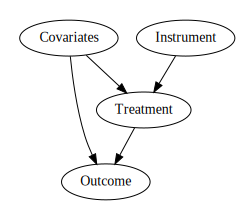

In [2]:
dot = graphviz.Digraph("causal-graph",comment="A simple causal graph with confounders",filename="instrumental_variable_graph.gv")
dot.attr(rank="same")
with dot.subgraph(name="cluster_0") as c:
    c.attr(color="white")
    c.node("X",label="Covariates")
dot.node("Y",label="Outcome")
dot.edge("X","Y")
with dot.subgraph(name="cluster_1") as d:
    d.attr(color="white")
    d.node("T",label="Treatment")
dot.edge("T","Y")
dot.edge("X","T")
dot.node("I",label="Instrument")
dot.edge("I","T")
dot.edge_attr.update(arrowsize="1")
dot

### 1.1 Dataset generation

Let $X^{Nxd}$ be the matrix of $N$ observations and $d$ covariates, $Z^{nx1}$ the vector of instruments, $T^{nx1}$ the vector of treatment assignments and $Y^{nx1}$ the vector of outcomes.   
Let $C^{nx1}$ be the vector of compliers when recommended (when Z=1) and $C0^{nx1}$ the vector of non-compliers when not recommended (when Z==0)

We make the following assumptions:  
- binary instruments
- binary treatments that depend on compliance with instrument
- treatment allocation depends on the confounding covariates
- five continuous, normally distributed covariates
- constant treatment effect (ATE)
- independence of the covariates, i.e. $\Sigma = \sigma^2I$
- no additive noise in the outcomes, i.e. $\epsilon=0$

  
Then, the data is generated according to the following equations:
\begin{align*}
& X_i \sim \mathcal{N}(0,\Sigma) \\\\
& Z_i \sim Bernoulli(0.5) \\\\
& C_i \sim Bernoulli \left( 0.8 * \frac{1}{1+exp(X_{i,1} \otimes X_{i,2} + 3*X_{i,3})} \right)  \\\\
& C0_i \sim Bernoulli(0.006) \\\\
& T = C * Z + C0 * (1-Z) \\\\
& Y_i = \tau(X_i) T_i + \mu_0(X_i) + \epsilon
\end{align*}
where $i$ indexes individual units, $\tau$ describes the following true treatment effect, which depends linearly on all covariates:
\begin{equation*}
\tau(X_i) = X_ib^T + e
\end{equation*}
where $b$ is a 1xd vector of $b_i \sim U(0.4,0.7)$ weights for each covariate and $e \sim \mathcal{N}(0,0.05)$ gaussian noise.  
... and  $\mu_0(x)$ describes the following transformation of the covariates (to keep things interesting):
\begin{equation*}
\mu_0(X_i) = X_{i,1} \otimes X_{i,2} + X_{i,3} + X_{i,4} \otimes X_{i,5} 
\end{equation*}




## 1.2 Preprocessing
Now we apply CausalTune's built-in preprocessing pipeline and construct train/val/test sets

In [2]:
dataset = generate_synthetic_data(n_samples=1000, confounding=True, add_instrument=True)
data_df, features_X, features_W = preprocess_dataset(
    dataset.data, treatment=dataset.treatment, targets=dataset.outcomes
)
# drop true effect:
features_X = [f for f in features_X if f != "true_effect"]
print(f"features_X: {features_X}")
print(f"features_W: {features_W}")
data_df.head(10)

features_X: ['X1', 'X2', 'X3', 'X4', 'X5', 'instrument']
features_W: ['random']


,treatment,outcome,X1,X2,X3,X4,X5,true_effect,instrument,random
0,0.0,0.310450,0.321566,-0.002646,0.292278,0.193829,0.098143,0.545479,0.0,0.0
1,0.0,0.704427,-0.028057,0.526073,0.789129,-0.270635,0.258439,0.718200,1.0,0.0
2,0.0,0.257785,-0.179442,-0.514794,0.221956,0.170140,-0.332356,-0.352991,0.0,1.0
3,1.0,-0.937510,-0.197276,0.182559,-0.487816,-0.173994,-0.043628,-0.421270,1.0,1.0
4,0.0,0.143018,-0.200567,0.061728,-0.079406,-0.901427,-0.260481,-0.840449,0.0,1.0
5,0.0,-0.393860,-0.666970,0.427555,-0.132778,0.082254,0.292811,-0.006324,0.0,0.0
6,0.0,0.054023,-0.387708,-0.138017,0.003688,-0.170617,0.018612,-0.430020,1.0,0.0
7,0.0,-0.254244,0.276577,-0.796773,-0.061885,-0.128397,-0.218151,-0.543758,1.0,0.0
8,0.0,0.239907,0.143716,0.070400,0.248807,-0.299895,0.063416,0.116872,0.0,1.0
9,0.0,0.197732,0.037602,-0.193960,0.092252,0.289970,0.388911,0.349242,0.0,1.0


## 1.3 Model fitting
Now we're ready to find the best fitting model, given a user-specified metric. As we'd like to compare different metrics, we'll be doing this in a for-loop

In [6]:
for i_run in range(1, n_runs+1):

    train_df, test_df = train_test_split(data_df, test_size=test_size)
    test_df = test_df.reset_index(drop=True)

    for i, metric in enumerate(metrics):

        ac = CausalTune(
            metric=metric,
            verbose=1,
            components_verbose=1,
            components_time_budget=components_time_budget,
            estimator_list=estimator_list,
        )

        ct.fit(
            train_df,
            treatment="treatment",
            outcome="outcome",
            instruments=["instrument"],
            common_causes=features_W,
            effect_modifiers=features_X,
        )
        scores = {}
        # compute relevant scores (skip newdummy)
        for est_name, scr in ct.scores.items():
            if "NewDummy" not in est_name:

                causal_estimate = scr["estimator"]

                scr["scores"]["test"] = ct.scorer.make_scores(
                    causal_estimate,
                    test_df,
                    problem=ct.problem,
                    metrics_to_report=ct.metrics_to_report,
                )
                
                # add ground truth for convenience
                scr["scores"]["test"]["CATE_groundtruth"] = test_df["true_effect"]
                scr["scores"]["test"]["CATE_est"] = scr["estimator"].estimator.effect(test_df)
                scores[est_name] = scr["scores"]["test"]

        results = {
            "best_estimator": ct.best_estimator,
            "best_config": ct.best_config,
            "best_score": ct.best_score,
            "optimised_metric": metric,
            "scores_per_estimator": scores,
        }
        with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}.pkl", "wb") as f:
            pickle.dump(results, f)



[flaml.tune.tune: 09-21 09:18:21] {335} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-21 09:18:21] {456} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': 1}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


[flaml.tune.tune: 09-21 09:22:34] {456} INFO - trial 2 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}
[flaml.tune.tune: 09-21 09:24:47] {456} INFO - trial 3 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}
[flaml.tune.tune: 09-21 09:26:47] {456} INFO - trial 4 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}
[flaml.tune.tune: 09-21 09:30:49] {456} INFO - trial 5 config: {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}


In [12]:
dir(ct.results.trials[0])

['ERROR',
 'PAUSED',
 'PENDING',
 'RUNNING',
 'TERMINATED',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'config',
 'custom_trial_name',
 'experiment_tag',
 'generate_id',
 'is_finished',
 'last_result',
 'last_update_time',
 'metric_analysis',
 'metric_n_steps',
 'n_steps',
 'result_logger',
 'set_status',
 'start_time',
 'status',
 'trainable_name',
 'trial_id',
 'update_last_result',
 'verbose']

In [16]:
ct.results.trials[0].last_result.keys()

dict_keys(['energy_distance', 'estimator_name', 'scores', 'config', 'training_iteration', 'config/estimator', 'experiment_tag', 'time_total_s', 'estimator'])

## 1.4 Evaluation
How well did the different metrics quantify the mismatch between estimated and true treatment effects?

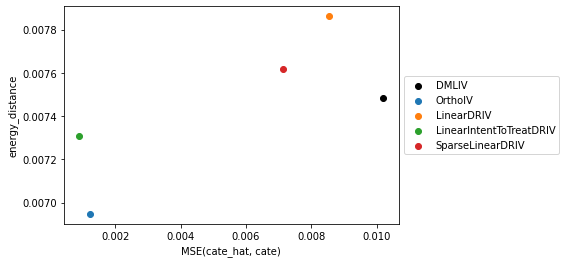

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

for metric in ["energy_distance"]:
    with open("../data/synthetic_observational_cate_instrument_"+metric+".pkl","rb") as f:
        results = pickle.load(f)
    
    plt.figure()
    
    for (est_name, scr), col in zip(ct.scores.items(),colors):
        if "NewDummy" in est_name:
            pass
        else:
            true_ate = scr["scores"]["test"]["CATE_groundtruth"]
            estimated_ate = scr["scores"]["test"]["CATE_est"]
            mse = np.mean((true_ate-estimated_ate)**2)
            plt.scatter(mse,scr["scores"]["test"][metric],color=col)
    plt.xlabel("MSE(cate_hat, cate)")
    plt.ylabel(ct.metric)
    plt.legend([k.split(".")[-1] for k in ct.scores.keys() if "NewDummy" not in k],loc='center left', bbox_to_anchor=(1, 0.5))